# Series de Tiempo

In [1]:
import pandas as pd
from numpy import mean
from numpy import median
from numpy import array
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
from math import sqrt
from sklearn.metrics import mean_squared_error

#
from warnings import catch_warnings
from warnings import filterwarnings

# La librería statsmodel tiene implementaciones de SARIMA y de Holt-Winters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Si el computador tiene procesadores múltiples, se aprovecharán
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed



# Métodos (funciones vistas en clase...y unas más)

In [2]:
# division_entreno_prueba([1,2,3,4,5],2)

def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

In [3]:
def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

In [4]:
# validación "walk-forward" para datos univariados
def validacion_al_frente(datos, n_prueba, metodo, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        if metodo == "promedio":
            yhat = prediccion_promedio(historia, cfg)
        elif metodo == "sarima":
            yhat = prediccion_sarima(historia, cfg)
        elif metodo == "exp":
            yhat = prediccion_alisamiento_exp(historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    return [error, predicciones]

In [5]:
def busqueda_malla(datos, lista_cfg, n_prueba, metodo = "sarima", paralelo = True):
    resultados = None
    if paralelo:
        # ejecutar las configuraciones en paralelo
        executor = Parallel(n_jobs = cpu_count(), backend = 'multiprocessing') 
        tareas = (delayed(calificar_modelo)(datos, n_prueba, metodo, cfg) for cfg in lista_cfg) 
        resultados = executor(tareas)
    else:
        resultados = [calificar_modelo(datos, n_prueba, metodo, cfg) for cfg in lista_cfg]
    # eliminar resultados vacíos
    resultados = [r for r in resultados if r[1] != None]
    return resultados

In [6]:
def calificar_modelo(datos, n_prueba, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir la confiuración a una llave
    llave = str(cfg)
    if debug:
        resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
    else:
        # una falla durante la validación del modelo sugiere una configuración inestable
        try:
        # nunca mostrar advertencias cuando se busca en malla...demasiado "ruido"
            with catch_warnings():
                filterwarnings("ignore")
                resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
        except:
            error = None
    if resultado is not None:
        print(f' > Modelo{llave} {resultado:.3f}')
    return (llave, resultado, predicciones)

In [7]:
def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
    datos = series.values
    resultados = []
    # dividir los datos
    n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
    long_max = len(datos) - n_prueba
    print(f"Tamaño Entrenamiento {long_max}")
    print(f"Tamaño Prueba {n_prueba}")

    # configuraciones de los modelos
    if metodo == "sarima":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_sarima()
    elif metodo == "promedio":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_simple(long_max)
    elif metodo == "exp":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_alisamiento_exp()
        datos = datos[:,0]
    # muestrear algunos
    if muestra:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        while len(resultados) < 5:
            lista_cfg_azar = random.sample(lista_cfg, k = 25)
            resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
    else:
        # búsqueda en malla
              
        # Si se tiene capacidad de procesamiento paralelo, paralelo = True (default)
        paralelo = True
        resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo, paralelo)
        
    
    # ordenan las configuraciones por error, ascendente
    resultados.sort(key = lambda tup: tup[1])

    print('terminado')
    # listar las mejores 3 configuraciones
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    # desplegar
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
    ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
    prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
    # Esconder las líneas de malla de la gráfica
    # ax.grid(False)

    # Esconder las marcas en los ejes
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
    plt.show()

# Predicción Promedio (Simple) 

In [8]:
def config_simple(long_max, offsets = [1]):
    configs = []
    for i in range(1, long_max + 1):
        for t in ['mediana',"promedio"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs

# prediccion de un paso por promedio
def prediccion_promedio(historia, config):
    n, tipo_promedio = config
    if tipo_promedio is 'promedio':
        return mean(historia[-n:])
    return median(historia[-n:])

# Ejemplo "simplón"

Mostrar al algoritmo siempre un conjunto más del conjunto prueba y dejar que prediga el siguiente, en forma iterativa.  Luego comparar la predicción entera al conjunto de prueba utilizando el error cuadrado medio.

In [9]:
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0)
datos = series.values
n_prueba = 100
long_max = len(datos) - n_prueba
cfg = config_simple(long_max)[1]
entreno = datos[:-n_prueba]
prueba = datos[-n_prueba:]
historia = [x for x in entreno]    
predicciones = []
for i in range(len(prueba)):
    yhat = prediccion_promedio(historia, cfg)
    predicciones.append(yhat)
    historia.append(prueba[i])

error = sqrt(mean_squared_error(prueba, predicciones))
error

7.892401408950257

# Predicción SARIMA 

In [10]:
def prediccion_sarima(historia, config):
    orden, orden_estacional, tendencia = config
    # definir el modelo
    modelo = SARIMAX(historia, order = orden, seasonal_order = orden_estacional, trend = tendencia,
      enforce_stationarity = False, enforce_invertibility = False)
    # ajustar el model con los datos
    modelo_ajustado = modelo.fit(disp = False)
    # hacer la predicción de un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

def config_sarima(estacional = [0]):
    modelos = []
    # definir las listas de configuración
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct'] 
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = estacional
    # crear instancias de configuración
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    modelos.append(cfg)
    return modelos

# Alisamiento Exponencial - Holt Winters

In [11]:
def prediccion_alisamiento_exp(historia, config):
    t, d, s, p, b, r = config
    # definir el modelo
    historia = array(historia)
    modelo = ExponentialSmoothing(historia, trend = t, damped_trend = d, 
                                  seasonal = s, seasonal_periods = p)
    # ajustar el modelo con los datos
    #modelo_ajustado = modelo.fit(optimized = True, use_boxcox = b, remove_bias = r)
    modelo_ajustado = modelo.fit(optimized = True, remove_bias = r)
    # predecir un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

#def config_alisamiento_exp(estacional = [4]):
def config_alisamiento_exp(estacional = [None]):
    modelos = []
    # definir las listas de config
    t_params = ['add', 'mul', None]
    d_params = [True, False] 
    s_params = ['add', 'mul', None]
    p_params = estacional
    b_params = [True, False]
    r_params = [True, False]
    # crear instancias de configuración
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            modelos.append(cfg)
    return modelos

# Caso: Ninguna tendencia - Nacimiento niñas

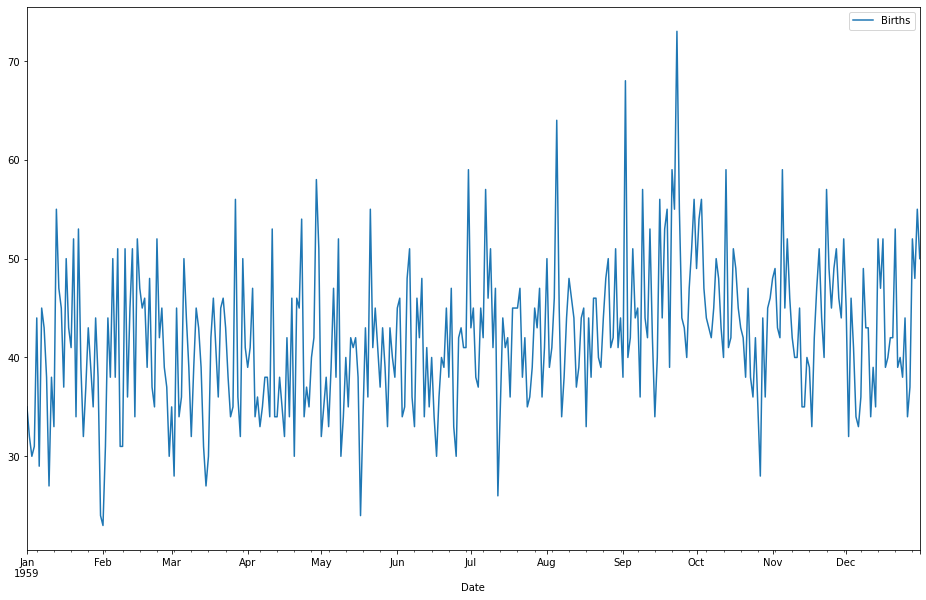

In [12]:
series = pd.read_csv('daily-total-female-births.csv', header=0, 
                     parse_dates = ["Date"], index_col = 0)
#import seaborn; seaborn.set()
series.plot(figsize=(16,10))
plt.savefig('nac_fem.png', transparent = True)

Tamaño Entrenamiento 292
Tamaño Prueba 73
Encontrando la mejor solución para promedio
 > Modelo[1, 'mediana'] 7.699 > Modelo[1, 'promedio'] 7.699 > Modelo[2, 'mediana'] 6.947


 > Modelo[3, 'mediana'] 6.781 > Modelo[4, 'mediana'] 6.771

 > Modelo[4, 'promedio'] 6.771 > Modelo[5, 'mediana'] 6.957

 > Modelo[5, 'promedio'] 6.957 > Modelo[6, 'mediana'] 6.747

 > Modelo[2, 'promedio'] 6.947
 > Modelo[3, 'promedio'] 6.781
 > Modelo[9, 'mediana'] 7.319 > Modelo[8, 'mediana'] 7.140 > Modelo[6, 'promedio'] 6.747
 > Modelo[9, 'promedio'] 7.319 > Modelo[7, 'mediana'] 6.886



 > Modelo[10, 'mediana'] 7.220
 > Modelo[7, 'promedio'] 6.886
 > Modelo[8, 'promedio'] 7.140
 > Modelo[13, 'mediana'] 7.285
 > Modelo[13, 'promedio'] 7.285
 > Modelo[14, 'mediana'] 7.170
 > Modelo[11, 'mediana'] 7.203
 > Modelo[11, 'promedio'] 7.203
 > Modelo[15, 'mediana'] 7.090
 > Modelo[12, 'mediana'] 7.270 > Modelo[15, 'promedio'] 7.090
 > Modelo[16, 'mediana'] 7.077

 > Modelo[16, 'promedio'] 7.077
 > Modelo[10, 'prome

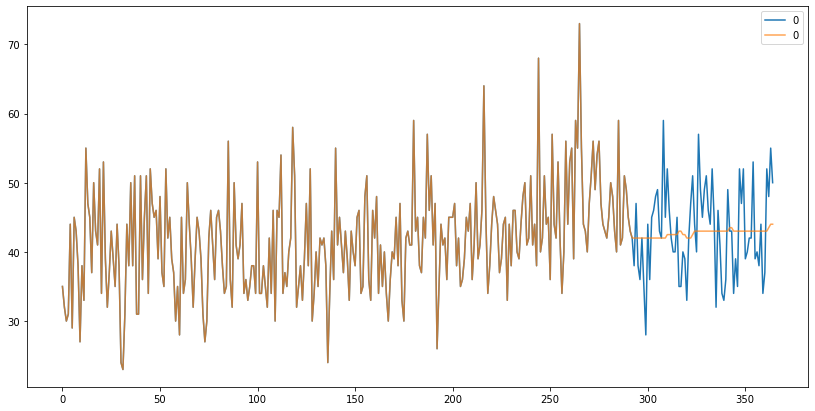

Tamaño Entrenamiento 292
Tamaño Prueba 73
Encontrando la mejor solución para sarima
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'n'] 43.504
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'c'] 6.535
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 't'] 22.627
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'n'] 25.208
 > Modelo[(0, 0, 0), (0, 0, 0, 0), 'ct'] 6.973
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'c'] 6.324
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 't'] 15.002
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'n'] 18.284
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'c'] 6.272
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'n'] 7.699
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'c'] 7.710
 > Modelo[(0, 0, 1), (0, 0, 0, 0), 'ct'] 6.718
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 't'] 7.734
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 't'] 12.052
 > Modelo[(0, 1, 0), (0, 0, 0, 0), 'ct'] 7.746
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 'n'] 6.788
 > Modelo[(0, 1, 1), (0, 0, 0, 0), 'c'] 6.938
 > Modelo[(0, 0, 2), (0, 0, 0, 0), 'ct'] 6.636
 > Modelo[(0, 1, 2), (0, 0, 0, 0), 'n'] 6.627
 > Modelo[(0, 1, 1), (0, 0, 0, 0

In [ ]:
series = pd.read_csv('daily-total-female-births.csv', header = 0, index_col = 0)
nombre = "nacimiento-feminas"
encontrar_mejor_solucion(series, nombre, metodo = "promedio")
encontrar_mejor_solucion(series, nombre, metodo = "sarima")
encontrar_mejor_solucion(series, nombre, metodo = "exp")

# Caso:  Con Tendencia - Ventas Shampoo

In [ ]:
series = pd.read_csv('shampoo.csv', header=0)
series["Year"] = [1998] * 12 + [1999] * 12 + [2000] * 12
series["Month"] = list(range(1,13)) * 3
series["Date"] = series["Month"].apply(str) + "-" + series["Year"].apply(str)
series['date']  = pd.to_datetime(series["Date"])
series = series[["date","Sales"]]
series.set_index(['date'],inplace = True)

import seaborn; seaborn.set()
series.plot(figsize = (16,10))
plt.savefig('shampoo.png')

In [ ]:
series = pd.read_csv('shampoo.csv', header = 0, index_col = 0)
nombre="shampoo"
encontrar_mejor_solucion(series, nombre, metodo = "promedio")
encontrar_mejor_solucion(series, nombre, metodo = "sarima")
encontrar_mejor_solucion(series, nombre, metodo = "exp")

# Caso:  Con Estacionalidad - Temperatura

In [ ]:
series = pd.read_csv('monthly-mean-temp.csv', header = 0, parse_dates = ["Month"])
series.set_index(['Month'],inplace=True)
import seaborn; seaborn.set()
series.plot(figsize = (16,10))
plt.savefig('temp.png')

In [ ]:
series = pd.read_csv('monthly-mean-temp.csv', header = 0, index_col = 0)
nombre = "temp"
encontrar_mejor_solucion(series, nombre, metodo = "promedio")
encontrar_mejor_solucion(series, nombre, metodo = "sarima")
encontrar_mejor_solucion(series, nombre, metodo = "exp")

# Caso: Con Tendencia y con Estacionalidad -  Venta mensual de carros

In [ ]:
series = pd.read_csv('monthly-car-sales.csv', header = 0,parse_dates = ["Month"])
series.set_index(['Month'], inplace = True)
import seaborn; seaborn.set()
series.plot(figsize = (16,10))
plt.savefig('cars.png')

In [ ]:
series = pd.read_csv('monthly-car-sales.csv', header=0, index_col=0)
nombre = "carros"
encontrar_mejor_solucion(series, nombre, metodo = "promedio")
encontrar_mejor_solucion(series, nombre, metodo = "sarima")
encontrar_mejor_solucion(series, nombre, metodo = "exp")